In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [13]:
pretrained_Model = tf.keras.applications.MobileNetV2(include_top = True, weights='imagenet')
pretrained_Model.trainable=False

In [14]:
import cv2
dir_path='../voltage_anomaly_detection/'
img = cv2.imread(dir_path+"cat/cat.0.jpg")

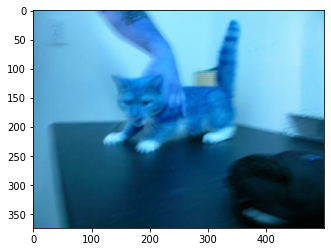

In [15]:
plt.imshow(img)

In [16]:
val_img = []
for file in os.listdir(dir_path+"cat/"): 
    val_img.append(cv2.imread(dir_path+'cat/'+file))

In [17]:
def preprocess(image):
    image=tf.cast(image,tf.float32)
    image/=255
    image=tf.image.resize(image,(224,224))
    image=image[None, ...]
    return image

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [18]:
preprocessed_images=[]
for i in range(0,len(val_img),1):
    img=preprocess(val_img[int(i)])
    preprocessed_images.append(img)

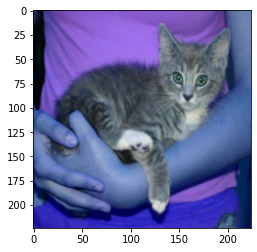

In [19]:
plt.imshow(preprocessed_images[2][0])

In [46]:
probs = []
for i in range(len(val_img)):
    image_probs=pretrained_Model.predict(preprocessed_images[i])
    probs.append(image_probs)

In [47]:
# ImageNet 클래스 레이블
decode_predictions=tf.keras.applications.mobilenet_v2.decode_predictions
classes=[]
for i in range(len(val_img)):
    _,image_class,class_confidence=get_imagenet_label(probs[i])
    classes.append(image_class)

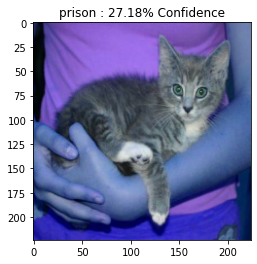

In [31]:
plt.figure()
plt.imshow(preprocessed_images[2][0])
_,image_class,class_confidence=get_imagenet_label(image_probs)
plt.title("{} : {:.2f}% Confidence".format(image_class, class_confidence*100))
plt.show()

In [43]:
from collections import Counter

def frequency_sort(data):
	rt_data = []
	for d, c in Counter(data).most_common():
		for i in range(c):
			rt_data.append(d)
	return rt_data

In [49]:
print(frequency_sort(classes))

['Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Egyptian_cat', 'Persian_cat', 'Persian

# 랜덤 패치 생성

In [204]:
patch = np.random.rand(56,56,3)

In [205]:
patch.shape

(56, 56, 3)

In [206]:
np.unique(patch)

array([3.01426796e-05, 4.69351293e-05, 7.02913295e-05, ...,
       9.99742692e-01, 9.99908797e-01, 9.99930459e-01])

In [207]:
padded_patch.shape

TensorShape([1, 224, 224, 3])

In [195]:
padded_patch=np.pad(patch, ((84,84), (84,84), (0, 0)), mode = 'constant', constant_values = 0)

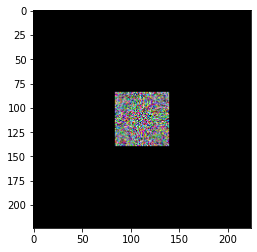

In [112]:
plt.imshow(padded_patch)

In [86]:
def convert_to_mask(gray_np_img):
    gray_np_img = np.asarray(gray_np_img).astype('float32') / 255.0
    mask_img = np.where(gray_np_img > 0, True, False)
    mask_img = np.tile(mask_img, (3,1,1))
    mask_img = np.transpose(mask_img, (1, 2, 0))
    return mask_img

In [113]:
#padded_patch = np.asarray(padded_patch).astype('float32') / 255.0
mask_img = np.where(padded_patch > 0, True, False)
print(mask_img.shape)

(224, 224, 3)


In [264]:
T = tf.keras.preprocessing.image.apply_affine_transform(theta=3,shear=1)

TypeError: apply_affine_transform() missing 1 required positional argument: 'x'

In [129]:
Unadv_example = preprocessed_images[2]*(tf.zeros((224,224,3))-T(1*mask_img))+T(padded_patch)*T(mask_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


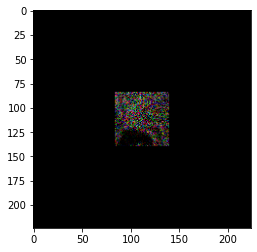

In [130]:
plt.imshow(Unadv_example[0])

In [142]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
def get_sign(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_Model(input_image)
        loss = loss_object(input_label, prediction)

      # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
    gradient = tape.gradient(loss, input_image)
      # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
    signed_grad = tf.sign(gradient)
    return signed_grad

In [189]:
persian_cat_index = 283
label = tf.one_hot(persian_cat_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

sign = get_sign(Unadv_example, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


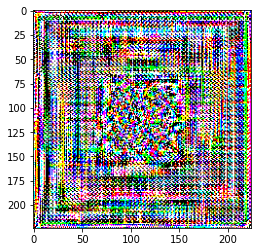

In [190]:
plt.imshow(sign[0])

In [191]:
sign[0].shape

TensorShape([224, 224, 3])

In [214]:
import random
from random import *
 
i = randint(1, 100)  # 1부터 100 사이의 임의의 정수
print(i)
for K in range(1000):
    # 무작위로 image-label 쌍 선택
    i = randint(0, len(preprocessed_images)-1)
    selected_image = preprocessed_images[i]
    selected_class = classes[i]
    if selected_class == "Egyptian_cat":
        padded_patch=np.pad(patch, ((84,84), (84,84), (0, 0)), mode = 'constant', constant_values = 0) # Zero-pad Patch
        mask = np.where(padded_patch > 0, True, False) # Mask
        Unadv_example = preprocessed_images[i]*(tf.zeros((224,224,3))-T(1*mask_img))+T(padded_patch)*T(mask_img)
        sign = get_sign(Unadv_example, label)
        padded_patch = padded_patch - 0.0001*sign


96


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


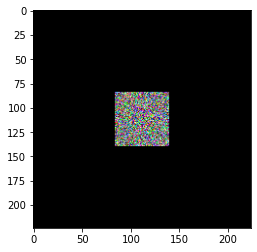

In [215]:
plt.imshow(padded_patch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


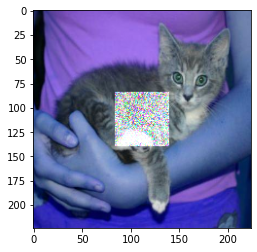

In [234]:
maked_image = preprocessed_images[2][0]+padded_patch[0]

plt.imshow(preprocessed_images[2][0]+padded_patch[0])

In [242]:
maked_image = np.array(maked_image).reshape((1,224,224,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


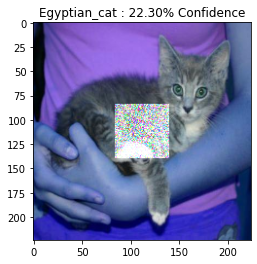

In [245]:
image_probs=pretrained_Model.predict(maked_image)
_,image_class,class_confidence=get_imagenet_label(image_probs)

plt.figure()
plt.imshow(maked_image[0])
_,image_class,class_confidence=get_imagenet_label(image_probs)
plt.title("{} : {:.2f}% Confidence".format(image_class, class_confidence*100))
plt.show()

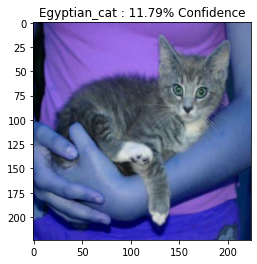

In [233]:
image_probs2=pretrained_Model.predict(preprocessed_images[2])
_,image_class,class_confidence=get_imagenet_label(image_probs2)

plt.imshow(preprocessed_images[2][0])
_,image_class,class_confidence=get_imagenet_label(image_probs2)
plt.title("{} : {:.2f}% Confidence".format(image_class, class_confidence*100))
plt.show()

In [232]:
classes

array(['Persian_cat', 'Siamese_cat', 'Egyptian_cat', 'Arctic_fox',
       'Egyptian_cat', 'Arctic_fox', 'lynx', 'Egyptian_cat', 'dishwasher',
       'Samoyed', 'Persian_cat', 'Persian_cat', 'Egyptian_cat',
       'tiger_cat', 'plastic_bag', 'Persian_cat', 'bassinet', 'hamster',
       'Egyptian_cat', 'Samoyed', 'toy_terrier', 'schipperke',
       'Siamese_cat', 'lynx', 'tabby', 'Persian_cat', 'Persian_cat',
       'tabby', 'Egyptian_cat', 'Siamese_cat', 'Egyptian_cat',
       'Persian_cat', 'plastic_bag', 'Egyptian_cat', 'ice_bear', 'tabby',
       'Egyptian_cat', 'Angora', 'Egyptian_cat', 'Persian_cat',
       'Egyptian_cat', 'toilet_tissue', 'Samoyed', 'Siamese_cat',
       'Persian_cat', 'Egyptian_cat', 'groenendael', 'Persian_cat',
       'tabby', 'tiger_cat', 'Siamese_cat', 'Egyptian_cat', 'groenendael',
       'jigsaw_puzzle', 'oxygen_mask', 'Old_English_sheepdog',
       'Egyptian_cat', 'Siamese_cat', 'Siamese_cat', 'Persian_cat',
       'oxygen_mask', 'Egyptian_cat', 'tabby', '

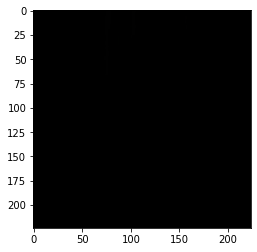

In [274]:
img = np.array(preprocessed_images[7][0])/255
plt.imshow(img)

In [277]:
patch = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)

In [281]:
patch = np.random.rand(56,56,3)

In [282]:
for K in range(900):
    # 무작위로 image-label 쌍 선택
    i = randint(0, len(preprocessed_images)-1)
    rand_theta = randint(0,6)
    rand_shear = randint(0,3)
    selected_image = preprocessed_images[i]
    selected_class = classes[i]
    if selected_class == "Egyptian_cat":
        padded_patch=np.pad(patch, ((84,84), (84,84), (0, 0)), mode = 'constant', constant_values = 0) # Zero-pad Patch
        mask = np.where(padded_patch > 0, True, False) # Mask
        T_mask = tf.keras.preprocessing.image.apply_affine_transform(1*mask_img,theta=rand_theta,shear=rand_shear)
        T_patch = tf.keras.preprocessing.image.apply_affine_transform(padded_patch,theta=rand_theta,shear=rand_shear)
        Unadv_example = preprocessed_images[i]*(tf.zeros((224,224,3))-T_mask)+T_patch*T_mask
        sign = get_sign(Unadv_example, label)
        padded_patch = padded_patch - 0.005*sign

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


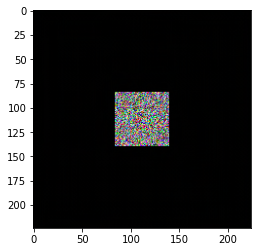

In [283]:
plt.imshow(padded_patch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


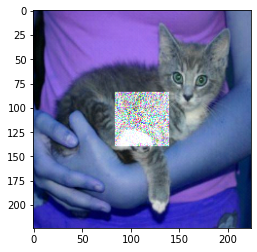

In [284]:
maked_image = preprocessed_images[2][0]+padded_patch[0]

plt.imshow(preprocessed_images[2][0]+padded_patch[0])

In [285]:
maked_image = np.array(maked_image).reshape((1,224,224,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


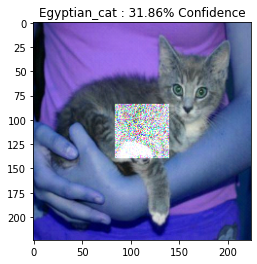

In [286]:
image_probs=pretrained_Model.predict(maked_image)
_,image_class,class_confidence=get_imagenet_label(image_probs)

plt.figure()
plt.imshow(maked_image[0])
_,image_class,class_confidence=get_imagenet_label(image_probs)
plt.title("{} : {:.2f}% Confidence".format(image_class, class_confidence*100))
plt.show()

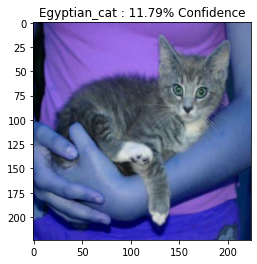

In [287]:
image_probs2=pretrained_Model.predict(preprocessed_images[2])
_,image_class,class_confidence=get_imagenet_label(image_probs2)

plt.imshow(preprocessed_images[2][0])
_,image_class,class_confidence=get_imagenet_label(image_probs2)
plt.title("{} : {:.2f}% Confidence".format(image_class, class_confidence*100))
plt.show()

In [288]:
classes

array(['Persian_cat', 'Siamese_cat', 'Egyptian_cat', 'Arctic_fox',
       'Egyptian_cat', 'Arctic_fox', 'lynx', 'Egyptian_cat', 'dishwasher',
       'Samoyed', 'Persian_cat', 'Persian_cat', 'Egyptian_cat',
       'tiger_cat', 'plastic_bag', 'Persian_cat', 'bassinet', 'hamster',
       'Egyptian_cat', 'Samoyed', 'toy_terrier', 'schipperke',
       'Siamese_cat', 'lynx', 'tabby', 'Persian_cat', 'Persian_cat',
       'tabby', 'Egyptian_cat', 'Siamese_cat', 'Egyptian_cat',
       'Persian_cat', 'plastic_bag', 'Egyptian_cat', 'ice_bear', 'tabby',
       'Egyptian_cat', 'Angora', 'Egyptian_cat', 'Persian_cat',
       'Egyptian_cat', 'toilet_tissue', 'Samoyed', 'Siamese_cat',
       'Persian_cat', 'Egyptian_cat', 'groenendael', 'Persian_cat',
       'tabby', 'tiger_cat', 'Siamese_cat', 'Egyptian_cat', 'groenendael',
       'jigsaw_puzzle', 'oxygen_mask', 'Old_English_sheepdog',
       'Egyptian_cat', 'Siamese_cat', 'Siamese_cat', 'Persian_cat',
       'oxygen_mask', 'Egyptian_cat', 'tabby', '

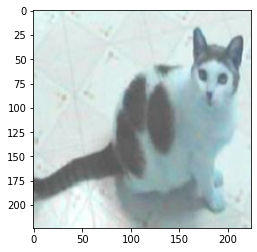

In [289]:
plt.imshow(preprocessed_images[5][0])

In [323]:
patch_img = preprocessed_images[5][0]

In [324]:
patch_img=preprocess(patch_img)
patch_img=np.array(patch_img).reshape((1,224,224,3))

In [325]:
patch_img.shape

(1, 224, 224, 3)

In [326]:
patch_img = cv2.resize(patch_img[0], None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)

In [327]:
patch_img.shape

(56, 56, 3)

In [328]:
patch_img=np.array(patch_img).reshape((1,56,56,3))

In [329]:
for K in range(900):
    # 무작위로 image-label 쌍 선택
    i = randint(0, len(preprocessed_images)-1)
    rand_theta = randint(0,100)
    rand_shear = randint(0,100)
    selected_image = preprocessed_images[i]
    selected_class = classes[i]
    if selected_class == "Egyptian_cat":
        padded_patch_img=np.pad(patch_img[0], ((84,84), (84,84), (0, 0))\
                                , mode = 'constant', constant_values = 0) # Zero-pad Patch
        mask_img = np.where(padded_patch_img > 0, True, False) # Mask
        T_mask = tf.keras.preprocessing.image.apply_affine_transform(1*mask_img,theta=rand_theta,shear=rand_shear)
        T_patch = tf.keras.preprocessing.image.apply_affine_transform(padded_patch_img,theta=rand_theta,shear=rand_shear)
        Unadv_example = preprocessed_images[i]*(tf.zeros((224,224,3))-T_mask)+T_patch*T_mask
        sign_ = get_sign(Unadv_example, label)
        padded_patch_img = padded_patch_img - 0.005*sign_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


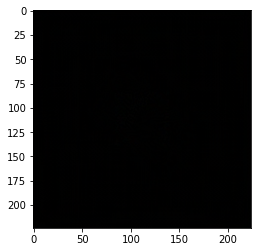

In [330]:
plt.imshow(padded_patch_img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


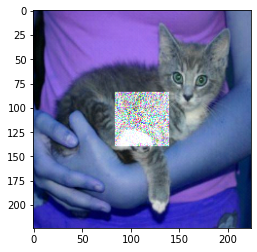

In [331]:
new_image = preprocessed_images[2][0]+padded_patch_img[0]

plt.imshow(preprocessed_images[2][0]+padded_patch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


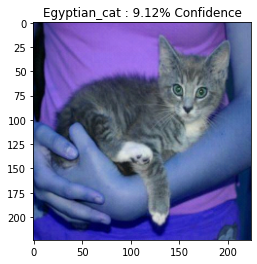

In [332]:
new_image = np.array(new_image).reshape((1,224,224,3))

image_probs=pretrained_Model.predict(new_image)
_,image_class,class_confidence=get_imagenet_label(image_probs)

plt.figure()
plt.imshow(new_image[0])
_,image_class,class_confidence=get_imagenet_label(image_probs)
plt.title("{} : {:.2f}% Confidence".format(image_class, class_confidence*100))
plt.show()